# Business Understanding

Text

In [1]:
reset -fs

In [2]:
# Importing the most important modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import time
from tqdm.notebook import tqdm

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import plotly.offline as pyo
from matplotlib.pyplot import cm
from IPython.display import Image

# Importing time series split for cross validation of time series models
from sklearn.model_selection import TimeSeriesSplit

# For Data Mining
import os, glob

# For Data Cleaning
from datetime import datetime
import missingno as msno

from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot
import matplotlib.dates as mdates

# Importing metrics to evaluate the implemented models
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Importing Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller

# Importing autocorrelation function and partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing ARIMA Model
from statsmodels.tsa.arima_model import ARIMA

# Automated search for optimal ARIMA order
import pmdarima as pm

# Importing fbprophet for Prophet Model
from fbprophet import Prophet

<ipython-input-2-1f0c63612ce8>:28: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



## Global Variables and Settings

In [3]:
# Setting the random seed for reproducability and several plotting style parameters
%matplotlib inline
plt.style.use('seaborn')
pyo.init_notebook_mode()
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

# Load Data

In [4]:
#data has been saved using a .pkl file. 
path = './data/df_small.pkl'
df = pd.read_pickle(path)
df.head(2)

target_losses_norm  dswrf_sfc_wm2  gust_sfc_ms  \
2018-01-01 06:00:00            0.425598            0.0    16.777032   
2018-01-01 06:10:00            0.404513            0.0    16.748651   

                      hpbl_sfc_m     msl_ms_pa  r_pl925_perc  shtfl_sfc_wm2  \
2018-01-01 06:00:00  1349.927656  99212.062500     89.975000     -58.444885   
2018-01-01 06:10:00  1350.376965  99220.020833     89.854167     -58.558706   

                       t_100m_k      t_2m_k  tcclow_sfc_perc  wdir_100m_dn  \
2018-01-01 06:00:00  280.079346  280.496348        99.375000     54.455224   
2018-01-01 06:10:00  280.057788  280.470277        99.354167     55.784078   

                     wdir_10m_dn  wsp_100m_ms  wsp_10m_ms  working_day  \
2018-01-01 06:00:00    51.936818    16.548291    9.772748        False   
2018-01-01 06:10:00    53.253883    16.589409    9.804977        False   

                     weekday//Monday  weekday//Saturday  weekday//Sunday  \
2018-01-01 06:00:00                1                  0                0   
2018-01-01 06:10:00                1                  0                0   

                     weekday//Thursday  weekday//Tuesday  weekday//Wednesday  \
2018-01-01 06:00:00                  0                 0                   0   
2018-01-01 06:10:00                  0                 0                   0   

                     hour//1  hour//2  hour//3  hour//4  hour//5  hour//6  \
2018-01-01 06:00:00        0        0        0        0        0        1   
2018-01-01 06:10:00        0        0        0        0        0        1   

                     hour//7  hour//8  hour//9  hour//10  hour//11  hour//12  \
2018-01-01 06:00:00        0        0        0         0         0         0   
2018-01-01 06:10:00        0        0        0         0         0         0   

                     hour//13  hour//14  hour//15  hour//16  hour//17  \
2018-01-01 06:00:00         0         0         0         0         0   
2018-01-01 06:10:00         0         0         0         0         0   

                     hour//18  hour//19  hour//20  hour//21  hour//22  \
2018-01-01 06:00:00         0         0         0         0         0   
2018-01-01 06:10:00         0         0         0         0         0   

                     hour//23  
2018-01-01 06:00:00         0  
2018-01-01 06:10:00         0

## Data Overview

The aim of this Data Science projekt is a to predict Feed-In Managment events and the  energy loss connected to these events. The target data (`target_losses_norm`) looks as followed. 

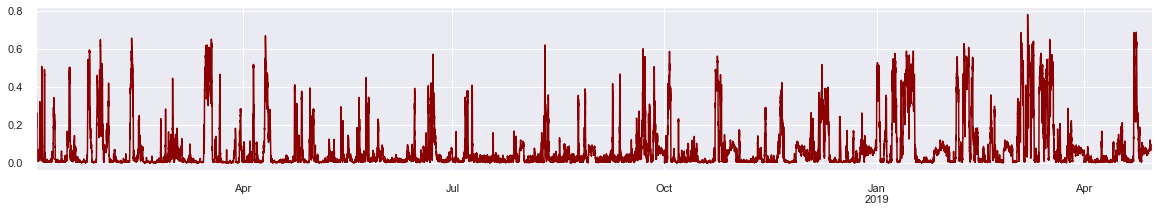

In [5]:
plot = df.target_losses_norm.plot(figsize=(20,3), color='darkred');
###### OUTPUT #######
plt.savefig('figures/overview_target.png', bbox_inches='tight', transparent=True)
plt.show();

In addition to the target data (endogenous variable), the above loaded Data Frame contains various meteorological parameters obtained from a numerical weather model (GFS data, e.g., `t_100m_k`) and categorical data (e.g., `summer`)  that can be used for predictions (exogenous variables). In the following graphs example Exogenous Features are shown in their variation over time. 

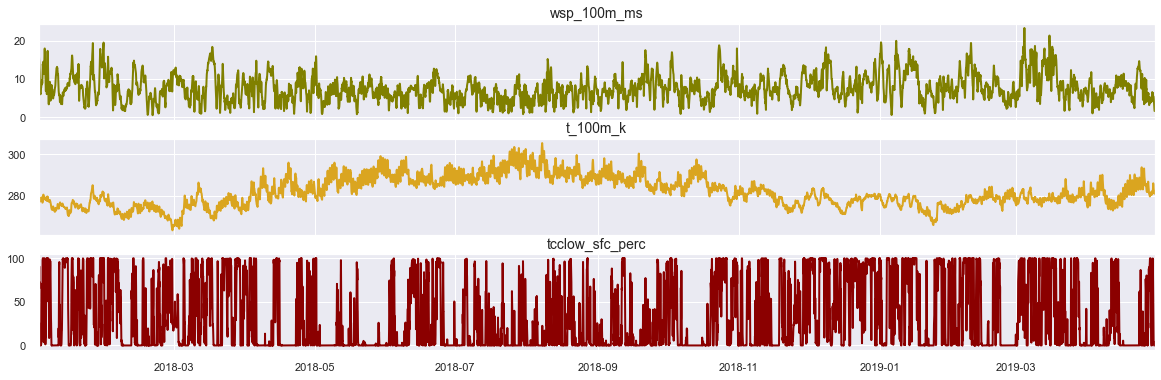

In [6]:
#### DATA SELECTION ####

f_to_plot = ['wsp_100m_ms', 't_100m_k','tcclow_sfc_perc']

#### PLOTTING #####
color=iter(['olive', 'goldenrod', 'darkred', 'sandybrown', 'sienna', 'grey'])
fig, axs = plt.subplots(len(f_to_plot), sharex=True, figsize=(20,len(f_to_plot)*2), facecolor='w')
for f, axes in zip(f_to_plot, axs): 
    c=next(color )
    axes.plot(df[f], color=c, lw=2)
    axes.set_title(f, fontsize=14)
    axes.set_xlim(left=df[f].index[0], right=df[f].index[-1])
###### OUTPUT #######
fig.savefig('figures/overview_GFS.png', bbox_inches='tight', transparent=True)
fig.show();

## Continuity Check

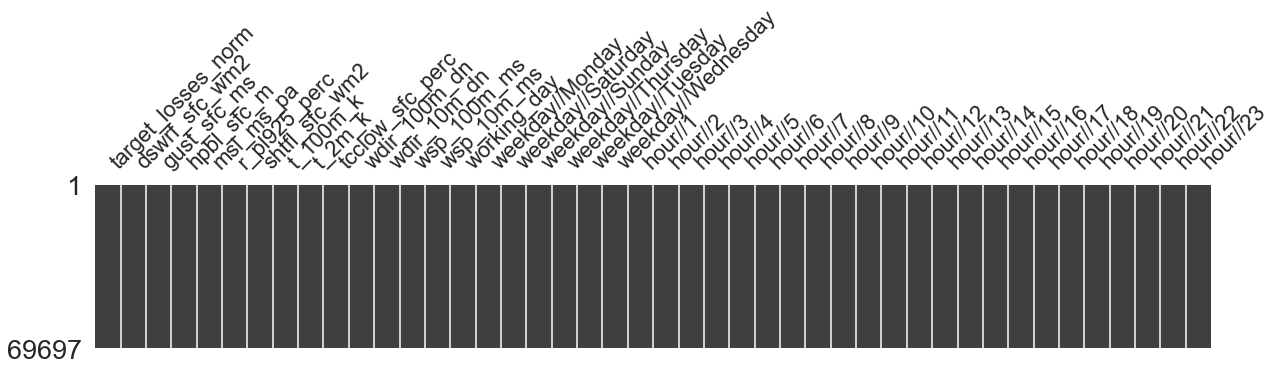

In [7]:
msno.matrix(df, figsize=(20, 3), sparkline=False, fontsize=22);

# Modeling

### Global Variable (Starting points of days to test models on)

In [8]:
test_timestamps = []
for i in range (10):
    test_timestamps.append(pd.to_datetime(df.index[-1]) - (i+1)*pd.Timedelta(hours=24))
test_timestamps.sort()
test_timestamps

[Timestamp('2019-04-20 06:00:00', freq='10T'),
 Timestamp('2019-04-21 06:00:00', freq='10T'),
 Timestamp('2019-04-22 06:00:00', freq='10T'),
 Timestamp('2019-04-23 06:00:00', freq='10T'),
 Timestamp('2019-04-24 06:00:00', freq='10T'),
 Timestamp('2019-04-25 06:00:00', freq='10T'),
 Timestamp('2019-04-26 06:00:00', freq='10T'),
 Timestamp('2019-04-27 06:00:00', freq='10T'),
 Timestamp('2019-04-28 06:00:00', freq='10T'),
 Timestamp('2019-04-29 06:00:00', freq='10T')]

In [9]:
val_timestamps = [pd.to_datetime("2019-03-17 06:00:00")]
for i in range (9):
    val_timestamps.append(pd.to_datetime(val_timestamps[0]) + (i+1)*pd.Timedelta(hours=24))
val_timestamps.sort()
val_timestamps

[Timestamp('2019-03-17 06:00:00'),
 Timestamp('2019-03-18 06:00:00'),
 Timestamp('2019-03-19 06:00:00'),
 Timestamp('2019-03-20 06:00:00'),
 Timestamp('2019-03-21 06:00:00'),
 Timestamp('2019-03-22 06:00:00'),
 Timestamp('2019-03-23 06:00:00'),
 Timestamp('2019-03-24 06:00:00'),
 Timestamp('2019-03-25 06:00:00'),
 Timestamp('2019-03-26 06:00:00')]

## General Functions

### Error Metrics Function (RMSE, R2, MAE, MAPE)

In [10]:
def error_metrics(y_pred, y_truth, model_name = "default"):
    """
    Calculate error metrics for a single comparison between predicted and observed values
    or the mean error metrics of multiple comparisons (inputs should be lists)
    """
    
    #checking if the inputs are lists or single arrays
    if isinstance(y_pred, list) and isinstance(y_truth, list):
        
        # creating empty arrays for the error metrics of the different splits
        RMSE = []
        R2 = []
        MAE = []
        MAPE = []
        
        # calculating and appending the error metrics for the different splits
        for i in range(len(y_pred)):
            RMSE.append(np.sqrt(mean_squared_error(y_truth[i], y_pred[i])))
            R2.append(r2_score(y_truth[i], y_pred[i]))
            MAE.append(mean_absolute_error(y_truth[i], y_pred[i]))
            MAPE.append((np.mean(np.abs((y_truth[i] - y_pred[i]) / y_truth[i])) * 100))
        
        # calculating the means of the error metrics
        RMSE_return = np.mean(RMSE)
        R2_return = np.mean(R2)
        MAE_return = np.mean(MAE)
        MAPE_return = np.mean(MAPE)
    
    # if inputs are single arrays
    else:
        
        # calculating error metrics
        RMSE_return = np.sqrt(mean_squared_error(y_truth, y_pred))
        R2_return = r2_score(y_truth, y_pred)
        MAE_return = mean_absolute_error(y_truth, y_pred)
        MAPE_return = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    
    # printing error metrics
    print('\nError metrics for {}'.format(model_name))
    print("RMSE or Root mean squared error: %.2f" % RMSE_return)
    print('R2-Score: %.2f' % R2_return )
    print('Mean Absolute Error: %.2f' % MAE_return)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE_return)
    
    # saving error metrics in a dataframe and returning it
    name_error = ['RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [RMSE_return, R2_return, MAE_return, MAPE_return/100]
    dict_error = dict()
    for i in range(len(name_error)):
        dict_error[name_error[i]] = [value_error[i]]
    errors = pd.DataFrame(dict_error).T
    errors.rename(columns={0 : model_name}, inplace = True)
    
    #path = './data/error_metrics_{}.pkl'.format(model_name)
    #errors.to_pickle(path)
        
    return(errors)

### Residual plot (prediction vs observation)

In [11]:
def plot_predvstrue_reg(pred, truth, model_name=None):
    """
    Plots the observed target_loss values against the predicted target_loss values
    """
    fig, ax = plt.subplots(1,1, figsize=(20,6))
    ax.scatter(truth, pred) 
    _ = plt.xlabel("Observed target_loss")
    _ = plt.ylabel("Predicted target_loss")
    _ = plt.title("Observed vs Predicted target_loss using model {}".format(model_name))
    _ = plt.xlim(1000, 5000)
    _ = plt.ylim(1000, 5000)
    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    _ = ax.plot(x, x)

### Plotting the true time series and the predicted time series in plotly interactive plot

In [12]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, start_date=None, end_date=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed target_loss vs predicted target_loss values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True, )
    
    fig.update_xaxes(type="date", range=[start_date, end_date])
    fig.show()

### Train-Test split that respects temporal order of observations

In [13]:
def train_test(data, begin_test, ignore_X = False):
    """
        Perform train-test split with respect to time series structure
        - df: dataframe with variables X_n to train on and the dependent output y which is the column 'target_losses_norm' in this notebook
        - test_size: size of test set 
    """
    df = data.copy()

    if ignore_X:
        # collecting the training and test data based on the calculated test_index (only the y-values)
        y_train = df.target_losses_norm[:begin_test-pd.Timedelta(minutes=10)]
        y_test = df.target_losses_norm[begin_test:]
        
        # printing the sizes of the whole dataset, the training set and the test set
        print('Observations: %d' % (len(df)))
        print('Training Observations: %d' % len(y_train))
        print('Testing Observations: %d' % len(y_test))
        
        return y_train, y_test
    else:
        # collecting the training and test data based on the calculated test_index
        X_train = df.drop('target_losses_norm', axis = 1)[:begin_test-pd.Timedelta(minutes=10)]
        y_train = df.target_losses_norm[:begin_test-pd.Timedelta(minutes=10)]
        X_test = df.drop('target_losses_norm', axis = 1)[begin_test:]
        y_test = df.target_losses_norm[begin_test:]
        
        # printing the sizes of the whole dataset, the training set and the test set
        print('Observations: %d' % (len(df)))
        print('Training Observations: %d' % len(y_train))
        print('Testing Observations: %d' % len(y_test))

        return X_train, X_test, y_train, y_test
    

### Multiple Train-Test splits that respect temporal order of observations

In [14]:
def mul_train_test(data, n_splits=3):
    """
        Perform multiple train-test splits with respect to time series structure
        - df: dataframe with variables X_n to train on and the dependent output y which is the column 'target_losses_norm' in this notebook
        - n_splits: number of splits  
    """
    #creating copy of input data
    df = data.copy()
    
    #initializing TimeSeriesSplit with chosen number of splits
    splits = TimeSeriesSplit(n_splits)
    
    #separating label from features
    X = df.drop('target_losses_norm', axis = 1)
    y = df.target_losses_norm
    
    #initializing empty lists for X_train, X_test, y_train and y_test
    mul_X_train = []
    mul_X_test = []
    mul_y_train = []
    mul_y_test = []

    #creating multiple splits and storing the train and test sets in lists while also printing the corresponding sizes
    #of the whole set, the training set and the test set for each split
    for train_index, test_index in splits.split(df):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        print('Observations: %d' % (len(df)))
        print('Training Observations: %d' % (len(X_train)))
        print('Testing Observations: %d' % (len(X_test)))
        mul_X_train.append(X_train)
        mul_y_train.append(y_train)
        mul_X_test.append(X_test)
        mul_y_test.append(y_test)
    
    return mul_X_train, mul_X_test, mul_y_train, mul_y_test



## Naive Base Model

First a naive base model is implemented. This model always predicts the last seen value as the next.

In [15]:
naive = df["target_losses_norm"].to_frame().copy(deep= True)
naive["predicted"] = naive["target_losses_norm"].shift(1)
naive = naive.dropna()
naive.columns = ['y_test', 'y_pred']
naive.head(2)

y_test    y_pred
2018-01-01 06:10:00  0.404513  0.425598
2018-01-01 06:20:00  0.405137  0.404513

In [16]:
# setting up a dataframe for the results
naive_results = pd.DataFrame(columns = ["y_test", "y_pred"])

for tfstart in val_timestamps:
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours=24)
    naive_results = naive_results.append(naive[(naive.index >= tfstart) & (naive.index <= tfend)])
    
    # plotting the predicted values and the true values
    plot_ts_pred(naive[(naive.index >= tfstart) & (naive.index <= tfend)]["y_test"], 
                 naive[(naive.index >= tfstart) & (naive.index <= tfend)]["y_pred"], 
                 #start_date=test_timestamps[0], 
                 #end_date=pd.to_datetime(test_timestamps[0]) + pd.Timedelta(hours=24), 
                 model_name="Naive Base Model", 
                 og_ts_opacity = 0.8, 
                 pred_ts_opacity = 0.8)

In [17]:
# evaluating the naive base model for the test data and saving metrics in dictionary for later use
error_metrics_naive_base_model = error_metrics(naive_results["y_pred"], naive_results["y_test"], "Naive Base Model on validation set")
error_metrics_naive_base_model


Error metrics for Naive Base Model on validation set
RMSE or Root mean squared error: 0.02
R2-Score: 0.99
Mean Absolute Error: 0.01
Mean Absolute Percentage Error: 14.55 %


Naive Base Model on validation set
RMSE                            0.015908
R2                              0.989822
MAE                             0.007114
MAPE                            0.145508

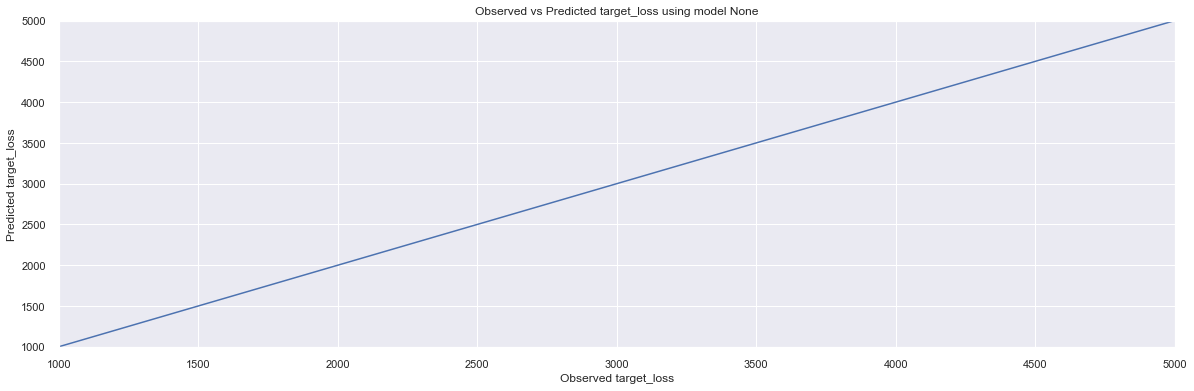

In [18]:
# plotting the predicted values against the true values
plot_predvstrue_reg(naive_results["y_pred"],naive_results["y_test"]);

## Exponential Smoothing

In [19]:
span = 2 #averaging over the last 30 minutes
ExpoSmoo = df[["target_losses_norm"]].copy(deep= True)
# Applying the  exponential weighted (EW) functions and then the mean
ExpoSmoo["y_pred"] = ExpoSmoo.rolling(window=span, min_periods=span).mean()
ExpoSmoo = ExpoSmoo.dropna()
ExpoSmoo.columns = ['y_test', 'y_pred']
ExpoSmoo.head(2)

y_test    y_pred
2018-01-01 06:10:00  0.404513  0.415056
2018-01-01 06:20:00  0.405137  0.404825

In [20]:
ExpoSmoo_results = pd.DataFrame(columns = ["y_test", "y_pred"])

for tfstart in val_timestamps:
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours=24)
    ExpoSmoo_results = ExpoSmoo_results.append(ExpoSmoo[(ExpoSmoo.index >= tfstart) & (ExpoSmoo.index <= tfend)])
    # plotting the predicted values and the true values
    plot_ts_pred(ExpoSmoo[(ExpoSmoo.index >= tfstart) & (ExpoSmoo.index <= tfend)]["y_test"], 
                 ExpoSmoo[(ExpoSmoo.index >= tfstart) & (ExpoSmoo.index <= tfend)]["y_pred"], 
                 #start_date=test_timestamps[0], 
                 #end_date=pd.to_datetime(test_timestamps[0]) + pd.Timedelta(hours=24), 
                 model_name="Exponential Smoothing Model", 
                 og_ts_opacity = 0.8, 
                 pred_ts_opacity = 0.8)

In [21]:
error_metrics_ExpoSmoo_model = error_metrics(ExpoSmoo_results["y_pred"], ExpoSmoo_results["y_test"], "Exponential Smoothing on validation set")
error_metrics_ExpoSmoo_model


Error metrics for Exponential Smoothing on validation set
RMSE or Root mean squared error: 0.01
R2-Score: 1.00
Mean Absolute Error: 0.00
Mean Absolute Percentage Error: 7.28 %


Exponential Smoothing on validation set
RMSE                                 0.007954
R2                                   0.997455
MAE                                  0.003557
MAPE                                 0.072754

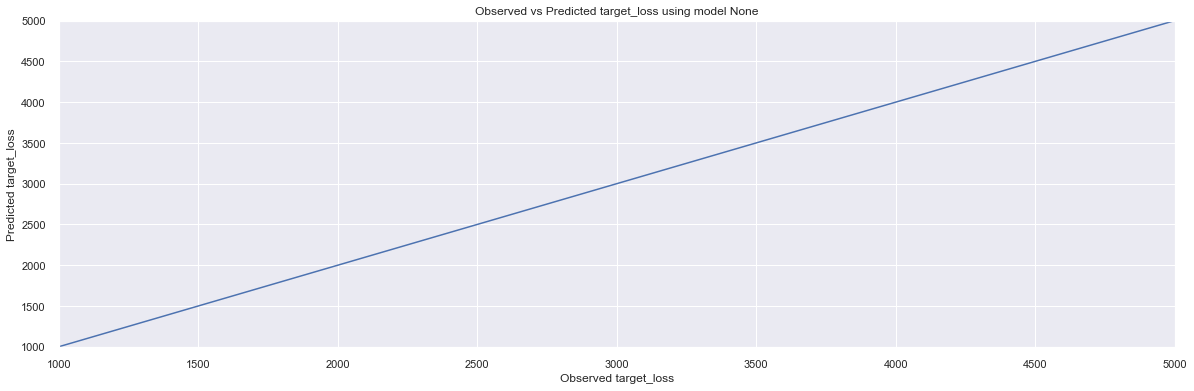

In [22]:
plot_predvstrue_reg(ExpoSmoo_results["y_pred"],ExpoSmoo_results["y_test"])

## FB Prophet

Adding squared windspeeds as features

In [23]:
df["wsp_100m_ms_squared"] = np.square(df.wsp_100m_ms)
df["wsp_10m_ms_squared"] = np.square(df.wsp_10m_ms)

In [24]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [25]:
def rolling_prophet_model(data, tfstart, prediction_window_size_hrs = 24, train_window_size_days = 90, 
                          lags = 1, logtransformation = True, differencing = True, target_name = "target_losses_norm",
                          filename = "results.csv"):
    """
        Predict values with a Prophet Model for a chosen timespan with a rolling-forward training window of a
        chosen size.
        - data: input dataframe
        - tfstart: start timestamp of the timespan to predict for
        - prediction_window_size_hrs: size of the prediction window in hours
        - train_window_size_days: size of the training window in days
        - lags: number of lags of the target_variable that should be included in the dataframe
        - logtransformation: should the target variable be transformed with the log-function for the prediction
        - differencing: should the target variable be differenced for the prediction
        - target_name: column name of the target variable
        - filename: chosen name for the file to be saved
        
    """
    #creating a working data frame to not change the actual input dataframe
    workframe = data.copy(deep = True)
    
    #if logtransformation is wanted
    if logtransformation == True:
        workframe[target_name] = np.log(workframe[target_name])
    
    #if lags should be included, they will be generated
    for i in range(lags):
        workframe[f"lag{i+1}"] = workframe[target_name].shift(i+1)
        
    #nan values after creation of lags will be dropped
    workframe.dropna(inplace = True)

    #when differencing is chosen
    if differencing == True:
        #creating another copy to keep the undifferenced values for backtransformation
        workframe_real = workframe.copy(deep = True)
        
        #calculating the differenced values for the target column
        workframe[target_name] = workframe[target_name].diff(1)
        
        #calculating the differenced values for the included lags
        if lags >= 1:
            for i in range(lags):
                workframe[f"lag{i+1}"] = workframe[f"lag{i+1}"].diff(1)
    
    #nan values after creation of lags will be dropped
    workframe.dropna(inplace = True)
        
    #setting start point of initial training window dependent on training window size
    train_start = pd.to_datetime(tfstart) - pd.Timedelta(days = train_window_size_days)
    
    #setting end point of test set dependent on chosen prediction window size
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours = prediction_window_size_hrs)
    
    #making working dataframe compatible with fbprophet
    workframe.rename(columns={target_name: "y"}, inplace = True)
    
    #splitting data in train and test
    df_test = workframe[(workframe.index >= tfstart) & (workframe.index <= tfend)]    
    df_train = workframe[(workframe.index >= train_start) & (workframe.index < tfstart)]
    
    #when differencing is chosen
    if differencing == True:
        #making the copy with the undifferenced target values compatible with prophet
        workframe_real.rename(columns={target_name: "y"}, inplace = True)
        
        #creating copy of the undifferenced test data for later evalutation against predictions 
        y_test = workframe_real[(workframe_real.index >= tfstart) & (workframe_real.index <= tfend)]["y"]    
    else:
        y_test = df_test["y"]
        
    #saving all the additional regressors (not the target) in list
    regressors = list(df_train.columns)
    regressors.remove("y")
    
    #adding datestamps to dataframes for compatibility with fbprophet
    df_test["ds"] = df_test.index
    df_train["ds"] = df_train.index
    
    # setting up a list to store the prediction results in
    predictions = list()

    #iterating over the test set
    for t in tqdm(range(len(df_test))):
            
            #initializing new Prophet model
            model = Prophet()
            
            #adding all the regressors with the same hyperparameters
            for name in list(regressors):
                model.add_regressor(name, prior_scale = 1, standardize = True, mode='multiplicative')            
            
            #training the model on the current training dataframe with the saved initial parameters from the last model, if there was one
            try:
                model.fit(df_train, init = parameters);
            except NameError:
                model.fit(df_train);
            
            #saving the parameters of the fitted model for warm-start training of the next model
            parameters = stan_init(model)
            
            #the timestamp before the current prediciton timestep is calculated (only needed, when differencing is chosen)
            index_before = df_test.index[0] - pd.Timedelta(minutes = 10)

            #setting up future dataframe (only one step ahead) with all regressors filled in assumption of perfect forecast for regressors
            future = df_test.drop(columns = ["y"]).iloc[0].to_frame().T
            
            #predicting next timestep
            forecast = model.predict(future)
            
            
            # setting the physically possible boundaries of the predictions (must be between 0 and 1 after backtransformation) depending on the chosen transformations
            if (logtransformation == True) and (differencing == True):    
                if forecast["yhat"].iloc[0] + workframe_real.loc[index_before]["y"] < -30:
                     predictions.append(-30)
                elif forecast["yhat"].iloc[0] + workframe_real.loc[index_before]["y"] >= 0:
                     predictions.append(0)
                else:
                     predictions.append(forecast["yhat"].iloc[0] + workframe_real.loc[index_before]["y"])
                        
            elif (logtransformation == True) and (differencing == False):
                if forecast["yhat"].iloc[0] < -30:
                     predictions.append(-30)
                elif forecast["yhat"].iloc[0] >= 0:
                     predictions.append(0)
                else:
                     predictions.append(forecast["yhat"].iloc[0])
                        
            elif (logtransformation == False) and (differencing == True):
                if forecast["yhat"].iloc[0] + workframe_real.loc[index_before]["y"] < 0:
                     predictions.append(0)
                elif forecast["yhat"].iloc[0] + workframe_real.loc[index_before]["y"] >= 1:
                     predictions.append(1)
                else:
                    predictions.append(forecast["yhat"].iloc[0] + workframe_real.loc[index_before]["y"])
                    
            else:
                if forecast["yhat"].iloc[0] < 0:
                     predictions.append(0)
                elif forecast["yhat"].iloc[0] > 1:
                     predictions.append(1)
                else:
                     predictions.append(forecast["yhat"].iloc[0])
                              
            #dropping the left end point of the training dataframe            
            df_train.drop(df_train.index[0], inplace = True)
            
            #appending the left end point of the test dataframe to the training dataframe
            df_train = df_train.append(df_test.iloc[0].to_frame().T)
            
            #dropping the left end point of the test dataframe
            df_test.drop(df_test.index[0], inplace = True)
            
    #converting the predictions to a series object        
    y_pred = pd.Series(v for v in predictions)
    
    #setting the indices as they were 
    y_pred.index = y_test.index
    
    #renaming the series
    y_pred.name = "y_pred"
    
    #backtransformation to real values if logtransformation was used
    if logtransformation == True:
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
         
    #creating the dataframe that will be saved as a file
    df_save = pd.DataFrame(columns = ["y_pred","y_test"])
    df_save["y_pred"] = y_pred
    df_save["y_test"] = y_test
    df_save.to_csv(f"{filename}")
    print(f"Predictions and test values saved as: {filename}")
    
    #returning the dataframe with the results
    return df_save


In [26]:
results = rolling_prophet_model(data = df, tfstart = val_timestamps[0], prediction_window_size_hrs = 240,
                                train_window_size_days = 60, lags = 1, logtransformation = True, 
                                differencing = True, target_name = "target_losses_norm",
                                filename = "results_prophet_multiplicative_standardized_ps1_logarithm_differenced_firstlag_wssquared_60days.csv")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye


Predictions and test values saved as: results_prophet_multiplicative_standardized_ps1_logarithm_differenced_firstlag_wssquared_60days.csv


In [27]:
plot_ts_pred(results.y_test, 
             results.y_pred, 
             model_name="FB Prophet Model", 
             og_ts_opacity = 0.8,  
             pred_ts_opacity = 0.8)

In [28]:
error_metrics_fbprophet_model = error_metrics(results.y_pred, results.y_test, "FB Prophet Model")
error_metrics_fbprophet_model


Error metrics for FB Prophet Model
RMSE or Root mean squared error: 0.02
R2-Score: 0.99
Mean Absolute Error: 0.01
Mean Absolute Percentage Error: 14.43 %


FB Prophet Model
RMSE          0.015782
R2            0.990000
MAE           0.007216
MAPE          0.144333

In [29]:
test_results = rolling_prophet_model(data = df, tfstart = test_timestamps[0], prediction_window_size_hrs = 240,
                                train_window_size_days = 60, lags = 1, logtransformation = True, 
                                differencing = True, target_name = "target_losses_norm",
                                filename = "test_results_prophet_multiplicative_standardized_ps1_logarithm_differenced_firstlag_wssquared_60days.csv")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye


Predictions and test values saved as: test_results_prophet_multiplicative_standardized_ps1_logarithm_differenced_firstlag_wssquared_60days.csv


In [30]:
plot_ts_pred(test_results.y_test, 
             test_results.y_pred, 
             model_name="FB Prophet Model", 
             og_ts_opacity = 0.8,  
             pred_ts_opacity = 0.8)

In [31]:
error_metrics_fbprophet_model = error_metrics(test_results.y_pred, test_results.y_test, "FB Prophet Model")
error_metrics_fbprophet_model


Error metrics for FB Prophet Model
RMSE or Root mean squared error: 0.01
R2-Score: 0.99
Mean Absolute Error: 0.00
Mean Absolute Percentage Error: 8.45 %


FB Prophet Model
RMSE          0.011911
R2            0.993941
MAE           0.004937
MAPE          0.084502